# Differentiable Procedural Generation

The idea behind differentiable procgen is to solve for procgen parameters rather than hand tune them. Many popular roguelikes have hand-tuned procgen parameters. It is not clear how they were derived, what effect changing them has, or how they interact with each other. Here are some examples.

## Angband

https://github.com/angband/angband/blob/master/lib/gamedata/dungeon_profile.txt

```
params:11:50:200:2
tunnel:10:30:15:25:50
streamer:5:2:3:90:2:40
cutoff:100
```

## Crawl

https://github.com/crawl/crawl/blob/master/crawl-ref/source/dgn-layouts.cc

```c
// Make some rooms:
int doorlevel = random2(11);
int roomsize  = 4 + random2(5);
roomsize += random2(6); // force a sequence point between random calls
```

## NetHack

https://github.com/NetHack/NetHack/blob/NetHack-3.6.2/src/mklev.c

```c
if (!rn2(50))
```

## Pixel Dungeon

For example Pixel Dungeon's level generator https://github.com/watabou/pixel-dungeon/blob/master/src/com/watabou/pixeldungeon/levels/RegularLevel.java

```java
int nConnected = (int)(rooms.size() * Random.Float( 0.5f, 0.7f ));
```

# Differentiable Programming

Differentiable programing is the idea that programs can be differentiated. Usually this means automatic differentiation. Given a function `f` which returns a scalar value, return a new function `grad_f` which returns the slope of `f`.

```python
def tanh(x):                 # Define a function
    y = np.exp(-2.0 * x)
    return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)
```

# How Does This Apply To Procgen?

Given the gradient of a function, we can use gradient descent to find arguments for the function which minimize the output.

Consider generation as a function of parameters, and random input. The parameters will be optimized, which the random_input will serve as a source of randomness for the generator. Think of the parameters as the collection of magic numbers demonstrated in the roguelikes above, and random input as all the calls to `rand()`. Instead of calling `rand()` inside the generator, we'll call it outside and the pass random input in.

```python
def gen(parameters, random_input)
    # Use parameters and random_input to make dungeon
    return dungeon
```

Also consider a loss function as a function of parameters, random input, and a target value where the target value is a scalar.

```python
def loss(parameters, random_input, target):
    dungeon = gen(parameters, random_input)
    # score the dungeon and compare to target
    score = ???
    return (score - target) ** 2
```


If the loss function is differentiable (implying that the gen function is also differentiable) then the gradient of the score with respect to parameters can be calculated. Using gradient descent, the parameters can be adjusted to minimize loss.

After optimum parameters are found, the generator function can be called with new random inputs to produce fresh output.

`gen(optimized_parameters, np.random.rand(...))`

# Tips on writing generators

* Use 2d convolutions for map generators

    * Use a fixed kernel and find the optimum bias value or

    * Consider the kernel as a set of parameters and find the optimum kernel values
    
* Use multiple 'passes' or loops to condition the output

* Don't be afraid of having hundreds or more parameters. Gradient descent will probably still work.

# Tips on writing loss functions

* Start simple with one goal

* Add multiple goals by using addition `+`

* Train a small neural net to score generator output. Example: deriving a differentiable `num_connected_components` function is difficult, but training a small neural network to estimate the number of connected components is easier and differentiable.

* You might be tempeted to add magic numbers to you loss function. That's ok. You're entering the world of reparameterization. Instead of tweaking with weird magic numbers in the generator, you've shifted the problem around to have interpretable numbers in the loss function.

* Experiment with batch size, number of epochs, learning rate, starting parameters. Now you're entering hyperparameter land.



# Dependencies

`jax` and `jaxlib` for differentiable programming support

`matplotlib` and `seaborn` for plotting graphs

`tensorflow` for connected_components

`joblib` for creating training data faster

In [76]:
!true || pip install --upgrade jax jaxlib matplotlib seaborn tensorflow joblib

In [2]:
import sys

In [3]:
sys.version

'3.7.3 (default, Mar 27 2019, 16:54:48) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [5]:
import os
from joblib import Parallel, delayed
import multiprocessing
import time
import itertools

import numpy as onp
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax import grad, jit, vmap, random
from jax.scipy.special import logsumexp, expit
from jax.experimental import optimizers
import jax.experimental.stax as stax
import jax.random as random

import tensorflow as tf
from tensorflow.contrib.image import connected_components

/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aaron/anaconda3/envs/

In [6]:
num_cores = multiprocessing.cpu_count()

# Cave Generation

Let's start with a cave generator. The most popular way of generating caves is by thinking of them like cellular automata. The process consists of starting with random noise and then repeating these steps. A rule of thumb is to use five repetitions.

1. For each cell in the map, consider a 3x3 neighborhood.

2. Count each wall as a 1 and each open space as a 0.

3. Add up of the wall.

4. A cell remains a wall if 4 of its neighbors are walls, or becomes a wall if 5 or more of its neighbors are walls.

5. Otherwise, the cell is marked empty.

Jax's `conv` function with a one's kernel

$\begin{pmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{pmatrix}$

is a convenient way to calculate neighborhood sums.

In [81]:
cols = 21
rows = 21
WALL = 1.
SPACE = 0.

key = random.PRNGKey(1)
# kernel that counts number of adjacent 1's
kernel = jax.numpy.ones((1, 1, 3, 3))
print(kernel.shape)

def print_map(a, threshold=0.5):
    print(np.where(a[0, 0] > threshold , ord(' '), ord('#')).astype(np.uint8)._value.view(f'S{a.shape[2]}'))

def caves_discrete(p):
    a = np.where(random.uniform(key, shape=(rows, cols)) < p, SPACE, WALL)[None, None, :, :]
    for i in range(4):
        conv = jax.lax.conv(a, kernel, (1, 1), "SAME")
        a = np.where(np.logical_or((conv < 5.0), (a + conv < 4.0)), SPACE, WALL)
    return a

(1, 1, 3, 3)


In [82]:
print_map(caves_discrete(0.50))

[[b'############  #######']
 [b'###########       ###']
 [b'###########       ###']
 [b'############     ####']
 [b'############    #####']
 [b'## ####  ###    #####']
 [b'#   ###  ###     ####']
 [b'#   ###  ##      ####']
 [b'#   #######      ####']
 [b'##   #######    #####']
 [b'###   ###############']
 [b'#### ################']
 [b'#####################']
 [b'########    #########']
 [b'########    #########']
 [b'########    #########']
 [b'#####################']
 [b'#####################']
 [b'#####################']
 [b'#####################']
 [b'#####################']]


Let's create a continuous version of this generator - one that can be differentiated.

First, let's define the sigmoid function. The sigmoid function will map numbers from $[-\infty, +\infty]$ to $[0, 1]$. This will give the generator the liberty to use the full number line but at the end we can still fit the output between 0 and 1.

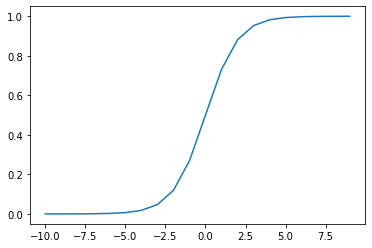

In [84]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

plt.plot(range(-10, 10), [sigmoid(x) for x in range(-10, 10)])

The continuous version of the caves generator uses the same kernel summing method, but has a free parameter: `threshold`. At each step we'll re-center the neighborhood sum and map the results into the range $[0, 1]$ by using the sigmoid function. We'll find the best `threshold` in just a bit.

The loss fuction for the caves generator runs the generator and finds the mean value of the output. Remember that the output is not just 0 or 1, but numbers in the range $[0, 1]$ so a mean of 0.5 would mean that on average every cell is half filled in.

In [85]:
def caves_continuous(params, x):
    # x (n, 1, w, h)
    threshold = params[0]
    k = int((kernel.shape[2]-2)/2)
    a = jax.lax.lax.pad(x,
                        WALL,
                        [(0, 0, 0),
                         (0, 0, 0),
                         (k, k, 0),
                         (k, k, 0)])
    for i in range(4):
        conv = jax.lax.conv_general_dilated(a, kernel, (1, 1), "SAME",
                                              dimension_numbers=("NCWH", 'OIWH', "NCWH"))
        # a is the sigmoid(sum of neighbors - threshold)
        a = sigmoid(conv - threshold)
    return a

def caves_loss_1(params, batch):
    x, y = batch
    out = caves_continuous(params, x)
    scores = np.mean(out, axis=(1, 2, 3))
    return np.mean((scores - y) ** 2.)

Let's use the caves loss function and see how the loss changes as the `threshold` parameter changes. We'll also differentiate the loss function so that we can also plot the slope.

[-12.5 -10.   -7.5  -5.   -2.5   0.    2.5   5.    7.5  10.   12.5]


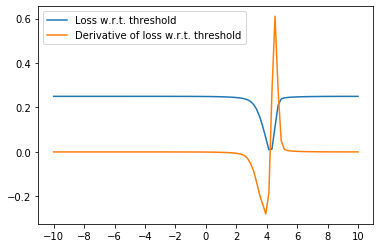

In [96]:
x = random.uniform(key, shape=(rows, cols))[None, None, :, :]
plt.plot(np.linspace(-10, 10, 100), [(caves_loss_1([p],(x, np.array([0.5]))))
          for p in np.linspace(-10, 10, 100)])
g = jit(grad(caves_loss_1))
plt.plot(np.linspace(-10, 10, 100), [g([p], (x, np.array([0.5])))
          for p in np.linspace(-10, 10, 100)])
locs, labels = plt.xticks()
print(locs)
plt.xticks(np.linspace(-10, 10, 11))
plt.legend(['Loss w.r.t. threshold', 'Derivative of loss w.r.t. threshold'])

It looks like the lowest loss is just above 4. Let's try it out and view the outputs as a spot check.

In [11]:
print_map(caves_continuous(np.array([4.3]), random.uniform(key, shape=(rows, cols))[None, None, :, :]))

[[b'#####################']
 [b'#############   #####']
 [b'##########       ####']
 [b'#########       #####']
 [b'#   ###         #####']
 [b'#    ##          ####']
 [b'#    ##          ####']
 [b'#    ##           ###']
 [b'#    #           ####']
 [b'##              #####']
 [b'##         ##########']
 [b'##         ##########']
 [b'###         #########']
 [b'#####         #######']
 [b'#####             ###']
 [b'#####              ##']
 [b'###    ####        ##']
 [b'##    ######       ##']
 [b'##   ########  ######']
 [b'### #################']
 [b'#####################']]


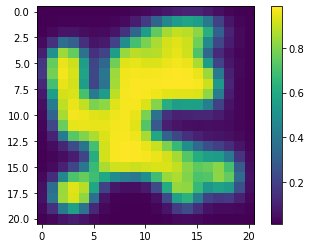

In [12]:
plt.imshow(caves_continuous([4.3], random.uniform(key, shape=(rows, cols))[None, None, :, :])[0,0,:,:])
plt.colorbar()

The spot check looks great. Let's move on to using jax.optimize to narrow in on the `threshold` which results in the lowest loss.

Input shape: (1024, 1, 21, 21)
Output shape (1024,)
Num Epochs: 32
Num Batches: 32

Starting training...
Epoch init 
Epoch 0 in 5.74 sec
Training set accuracy 0.2963680326938629
Test set accuracy 0.29634222388267517
Epoch 1 in 0.11 sec
Training set accuracy 0.29621028900146484
Test set accuracy 0.29620712995529175
Epoch 2 in 0.12 sec
Training set accuracy 0.29605358839035034
Test set accuracy 0.296037495136261
Epoch 3 in 0.13 sec
Training set accuracy 0.295862078666687
Test set accuracy 0.29586777091026306
Epoch 4 in 0.13 sec
Training set accuracy 0.29567718505859375
Test set accuracy 0.2956802248954773
Epoch 5 in 0.12 sec
Training set accuracy 0.29549694061279297
Test set accuracy 0.29548266530036926
Epoch 6 in 0.16 sec
Training set accuracy 0.2952577471733093
Test set accuracy 0.29527008533477783
Epoch 7 in 0.12 sec
Training set accuracy 0.2950310707092285
Test set accuracy 0.2950489819049835
Epoch 8 in 0.13 sec
Training set accuracy 0.29471468925476074
Test set accuracy 0.2947952151

DeviceArray([4.38171196], dtype=float32)

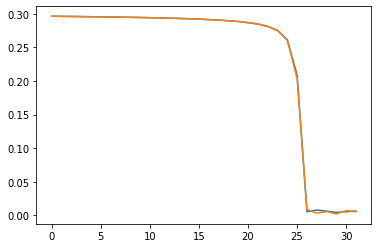

In [14]:
def cave_opt():
    init_rng = random.PRNGKey(0)
    step_size = 0.1
    momentum_mass = 0.9
    num_epochs = 32
    batch_size = 32
    train_X = np.squeeze(np.array([onp.random.rand(1, 1, rows, cols) for _ in range(num_epochs * batch_size)]), 1)
    train_y = np.array([.45 for _ in range(train_X.shape[0])])
    num_train = train_X.shape[0]
    num_complete_batches, leftover = divmod(train_X.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    print("Input shape:", train_X.shape)
    print("Output shape", train_y.shape)
    print("Num Epochs:", num_epochs)
    print("Num Batches:", num_batches)

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_X[batch_idx], train_y[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(caves_loss_1)(params, batch), opt_state)

    init_params = np.array([2.])
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    #train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    #losses.append(train_acc)
    #test_acc = test_accuracy(params)
    #test_accs.append(test_acc)
    print("Epoch init ")
    #print("Training set accuracy {}".format(train_acc))
    #print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        epoch_batch = None
        for _ in range(num_batches):
            batch = next(batches)
            epoch_batch = batch
            opt_state = update(rng, next(itercount), opt_state, batch)
        params = get_params(opt_state)
        losses.append(caves_loss_1(params, epoch_batch))
        test_accs.append(caves_loss_1(params, next(batches)))
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(losses[-1]))
        print("Test set accuracy {}".format(test_accs[-1]))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

cave_params = cave_opt()
cave_params

The optimizer found `4.38171196` as the `threshold` parameter with the lowest loss. Let's plug that back into the generator and feed it random starting noise.

[4.381712]
0.004916389


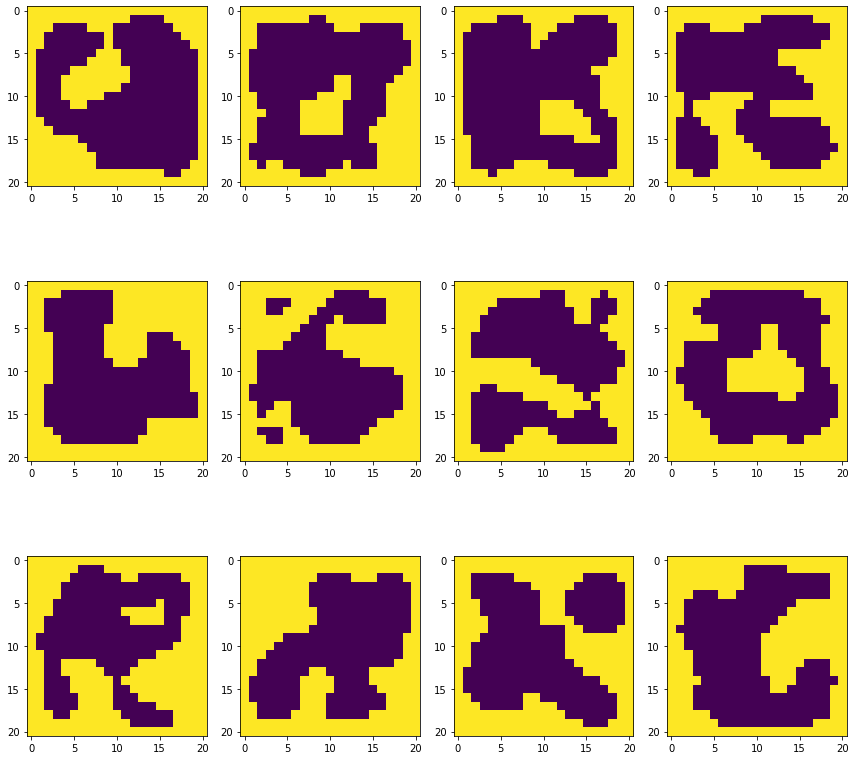

In [97]:
print(cave_params)
print(caves_loss_1(cave_params, (onp.random.rand(1, 1, rows, cols), np.array([0.45]))))

plt.subplots(figsize=(12, 12))

for i in range(1, 4):
    for j in range(1, 5):
        for _ in range(100):
            cs = np.where(caves_continuous(cave_params, onp.random.rand(1, 1, rows, cols)) > 0.5, 0., 1.)
            if np.sum(cs) < 250 :
                break
        plt.subplot(3, 4, (i - 1) * 4 + j)
        plt.imshow(onp.random.binomial(1, cs)[0, 0], vmin=0., vmax=1.)
plt.tight_layout()

This caves generator is a simple example. The loss function is concerned only with optimizing for density. Notice how sometimes the generator produces disconnected caverns. How could you modify the generator to optimize for connectedness?

# Graph Dungeon Generation

Let's move on to a more complicated dungeon generator - rooms and corridors. We'll need to draw the output, so let's define a drawing function.

In [98]:
dungeon_cols = 12
dungeon_rows = 12

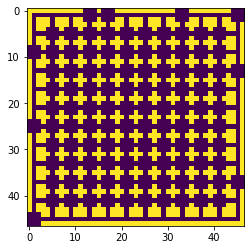

In [104]:
def make_dense_matrix(rows, cols):
    return np.zeros((1, 2, rows -1, cols - 1))

def draw_dense_dungeon(M):
    #M (batch, (0=horz/1=vert), row, col)
    rows = M.shape[2]
    cols = M.shape[3]
    #dungeon (row, col)
    dungeon = onp.ones((rows*4-1, cols*4-1))
    for row in range(rows):
        for col in range(cols):
            # TODO: logic. room
            # conn = 1. when there is a corridor
            conn = np.array([
                # above |
                row > 0 and M[0, 1, row - 1, col] == 1.,
                # below |
                row < rows - 1 and M[0, 1, row, col] == 1.,
                # left -
                col > 0 and M[0, 0, row, col - 1] == 1.,
                # right -
                col < cols - 1 and M[0, 0, row, col] == 1.]).astype(np.float32)
            if np.sum(conn) == 1. \
                or np.sum(conn) == 4. \
                or np.sum(conn) > 1. \
                    and onp.random.binomial(1, 0.85) == 0.:
                dungeon[4 * row : 4 * row + 3,
                        4 * col : 4 * col + 3] = 0.
            # horizontal corridors - (left and right)
            if col < cols - 1:
                corridor = M[0, 0, row, col]
                if corridor > 0.:
                    #dungeon[4 * row + 1, 4 * col + 3] = corridor
                    # d(row, col)
                    dungeon[4 * row + 1, (4 * col + 1):(4 * col + 6)] = 0.
            # vertical corridors | (above and below)
            if row < rows - 1:
                corridor = M[0, 1, row, col]
                if corridor > 0.:
                    #dungeon[4 * row + 3, 4 * col + 1] = corridor
                    dungeon[(4 * row + 1):(4 * row + 6), 4 * col + 1] = 0.
    return dungeon 

def plot_dense_dungeon(M):
    plt.imshow(draw_dense_dungeon(M), vmin=0., vmax=1.)
    
plot_dense_dungeon(np.ones((1, 2, dungeon_rows, dungeon_cols)))

Let's write a little dungeon generation function. Instead of having a fixed kernel like the caves generator, we'll let the kernel values be the target of optimization. The kernel will have the shape `(2, 2, 3, 3)` meaning `(num_iterations, horizontal/vertical corridors, width, height)`.

Finally, we can test the generator with a kernel of all `.1111`s.

[[[[0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]]

  [[0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]]]


 [[[0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]]

  [[0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]
   [0.11111111 0.11111111 0.11111111]]]]
171


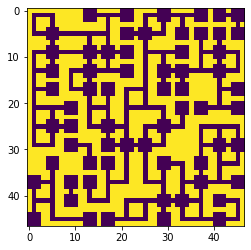

In [105]:
def dungeon(params, x):
    for i in range(2):
        kernel_a = params[i:i+1, 0:1, :, :]
        kernel_b = params[i:i+1, 1:2, :, :]
        a = x[:, 0:1, :, :]
        b = x[:, 1:2, :, :]
        conv_a = sigmoid(jax.lax.conv(a, kernel_a, (1, 1), "SAME"))
        conv_b = sigmoid(jax.lax.conv(b, kernel_b, (1, 1), "SAME"))
        x = np.stack([conv_a,
                      conv_b],
                     axis=2)[0]
    return x
dungeon_kernel = jax.numpy.ones((2, 2, 3, 3))/(3.*3.)
print(dungeon_kernel)
d = onp.random.binomial(1, dungeon(dungeon_kernel, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
print(np.sum(d))
plot_dense_dungeon(d)

# Dungeon Loss

Let's start with optimizing the dungeon for low density. 

Graph density
<img src="https://www.python-course.eu/images/graph_density_formula.png" />
is calculated using this formula where V is the number of verticies and E is the number of edges. We don't have an exact count of verticies and edges, so we'll say that every vertex is present in the graph (`width * height`) and then approximate the number of edges by summing the output which is conceptually a bit like the probability that a corridor is present.

Input shape: (1024, 2, 12, 12)
Output shape (1024,)
Num Epochs: 32
Num Batches: 32

Starting training...
Epoch init 
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 0 in 1.96 sec
Training set accuracy 6.374037742614746
Test set accuracy 6.374101161956787
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 1 in 0.12 sec
Training set accuracy 6.371424674987793
Test set accuracy 6.371812343597412
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 2 in 0.12 sec
Training set accuracy 6.370072364807129
Test set accuracy 6.370101451873779
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 3 in 0.12 sec
Training set accuracy 6.368484020233154
Test set accuracy 6.368983268737793
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 4 in 0.12 sec
Training set accuracy 6.366638660430908
Test set accuracy 6.367201328277588
(2, 2, 5, 5) (32, 

DeviceArray([[[[ 3.23586076e-01, -4.66847414e-04, -1.50759406e-02,
                -1.63056597e-01, -6.39308989e-01],
               [-3.80969606e-02,  1.03664197e-01,  6.29164875e-02,
                 5.11096835e-01, -4.92513001e-01],
               [ 3.54642682e-02,  4.55188721e-01, -4.03825134e-01,
                -1.56220704e-01,  6.40194356e-01],
               [-3.90211344e-01, -4.25166100e-01,  2.06913322e-01,
                 1.84730649e-01, -1.73343524e-01],
               [-2.55577356e-01,  6.00917459e-01,  3.56855869e-01,
                -3.85807782e-01, -7.83127606e-01]],

              [[-4.17999715e-01,  7.04828575e-02, -3.81044328e-01,
                 5.01143515e-01,  2.38347519e-03],
               [-4.70752008e-02,  3.69181693e-01, -5.42786956e-01,
                -1.39402568e-01, -2.52622485e-01],
               [-2.78140932e-01, -4.19204861e-01,  1.32831514e+00,
                -7.69589320e-02, -4.55870122e-01],
               [ 2.70145625e-01, -2.25423828e-01,  5.7

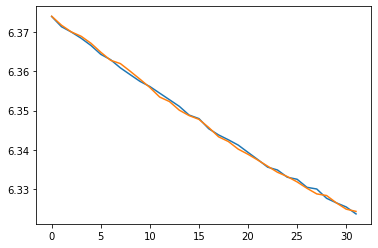

In [21]:
def dungeon_loss(params, batch):
    x, y = batch
    print(params.shape, x.shape, y.shape)
    out = dungeon(params, x)
    # map 0.0, 1.0 to -1.0, 1.0, convolve with kernel
    e = np.sum(out)
    v = np.prod(np.array(out.shape))
    d = 2. * e / (v * (v - 1.))
    return np.sum((d - y) ** 2.)

def dungeon_opt_1():
    init_rng = random.PRNGKey(0)
    step_size = 0.01
    momentum_mass = 0.9
    num_epochs = 32
    batch_size = 32
    train_X = np.squeeze(np.array([onp.random.rand(1, 2, dungeon_rows, dungeon_cols) for _ in range(num_epochs * batch_size)]), 1)
    train_y = np.array([.45 for _ in range(train_X.shape[0])])
    num_train = train_X.shape[0]
    num_complete_batches, leftover = divmod(train_X.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    print("Input shape:", train_X.shape)
    print("Output shape", train_y.shape)
    print("Num Epochs:", num_epochs)
    print("Num Batches:", num_batches)

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_X[batch_idx], train_y[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(dungeon_loss)(params, batch), opt_state)

    init_params = onp.random.randn(2, 2, 5, 5) * onp.sqrt(2/(2 + 5 + 5))
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    #train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    #losses.append(train_acc)
    #test_acc = test_accuracy(params)
    #test_accs.append(test_acc)
    print("Epoch init ")
    #print("Training set accuracy {}".format(train_acc))
    #print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        epoch_batch = None
        for _ in range(num_batches):
            batch = next(batches)
            epoch_batch = batch
            opt_state = update(rng, next(itercount), opt_state, batch)
        params = get_params(opt_state)
        losses.append(dungeon_loss(params, epoch_batch))
        test_accs.append(dungeon_loss(params, next(batches)))
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(losses[-1]))
        print("Test set accuracy {}".format(test_accs[-1]))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

dungeon_params_1 = dungeon_opt_1()
dungeon_params_1

The dungeons aren't really that great, huh? For one we're not taking into account the connectedness of the dungeons.

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 ...
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


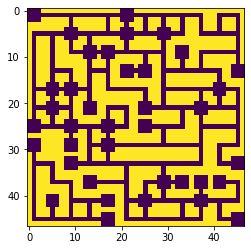

In [59]:
d = onp.random.binomial(1, dungeon(dungeon_kernel, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
print(draw_dense_dungeon(d))
plot_dense_dungeon(d)

So how can we bring connectedness into the loss function? Tensorflow's `connected_components` function while useful, isn't differentiable. It is still an open question of whether a differentiable form even exists.

[[1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 ...
 [0 4 0 ... 5 5 5]
 [0 4 4 ... 5 5 5]
 [0 0 0 ... 5 5 5]]
6


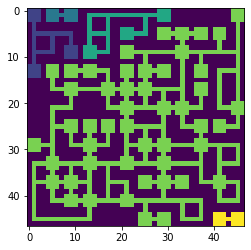

In [63]:
t = connected_components(draw_dense_dungeon(d) * -1. + 1.)
sess = tf.Session();
with sess.as_default():
    print(t.eval())
    print(len(onp.unique(t.eval())))
    plt.imshow(t.eval())

## Training a connected components model

What if we generated some dungeons, calculated the number of connected components, and used that as a dataset to train a deep learning model? The deep learning model is differentiable and could be called from the loss function! Let's do this. First create the dataset (or load it from disk because it takes a long time).

In [25]:
from tqdm import tqdm  
from os import path

num_epochs = 60
batch_size = 128

def gen(i):
    return onp.random.binomial(1, dungeon(dungeon_kernel, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
def gen_target(ti):
    sess = tf.Session()
    return len(onp.unique(connected_components(draw_dense_dungeon(ti) * -1. + 1.).eval(session=sess)))

if path.exists('cc_train.npy') and path.exists('cc_y.npy'):
    train_images = np.load('cc_train.npy')
    train_cc = np.load('cc_y.npy')
else:
    print('generating inputs')
    train_images = Parallel(n_jobs=num_cores)(delayed(gen)(i) for i in tqdm(range(num_epochs * batch_size)))
    print('generated responses')
    train_cc = Parallel(n_jobs=num_cores)(delayed(gen_target)(ti) for ti in tqdm(train_images))

    train_images = np.squeeze(np.stack(train_images), 1).astype(np.float32)
    train_cc = np.squeeze(np.stack(train_cc), 1).astype(np.float32)
    np.save('cc_train.npy', train_images)
    np.save('cc_y.npy', train_cc)

print(train_images.shape, train_images.dtype)
print(train_cc.shape, train_cc.dtype)

(7680, 2, 12, 12) float32
(7680,) float32


This is the distribution of the number of connected components in the dataset.

(array([2660., 1948., 1471.,  882.,  393.,  206.,   86.,   26.,    5.,
           3.]),
 array([ 2. ,  3.1,  4.2,  5.3,  6.4,  7.5,  8.6,  9.7, 10.8, 11.9, 13. ],
       dtype=float32),
 <a list of 10 Patch objects>)

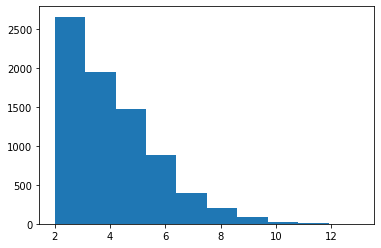

In [26]:
plt.hist(train_cc)

Let's setup a small convolutional neural network to estimate the number of connected components.

It trains quickly at first and gives ok, but not great results. If you can do better, let me know!


Starting training...
Epoch init 
Training set accuracy 42.33572769165039
Test set accuracy 48.7592658996582
Epoch 0 in 74.93 sec
Training set accuracy 2.752761125564575
Test set accuracy 2.028493642807007
Epoch 1 in 5.03 sec
Training set accuracy 2.655717611312866
Test set accuracy 0.6351049542427063
Epoch 2 in 4.90 sec
Training set accuracy 2.638641119003296
Test set accuracy 1.4454530477523804
Epoch 3 in 4.99 sec
Training set accuracy 2.6261518001556396
Test set accuracy 2.475154399871826
Epoch 4 in 5.29 sec
Training set accuracy 2.6168103218078613
Test set accuracy 2.4938056468963623
Epoch 5 in 5.29 sec
Training set accuracy 2.6097207069396973
Test set accuracy 3.248065948486328
Epoch 6 in 5.10 sec
Training set accuracy 2.6035754680633545
Test set accuracy 1.7035465240478516
Epoch 7 in 5.17 sec
Training set accuracy 2.59816575050354
Test set accuracy 1.6882177591323853
Epoch 8 in 5.05 sec
Training set accuracy 2.593513250350952
Test set accuracy 2.003343105316162
Epoch 9 in 5.12 se

[(DeviceArray([[[[-0.29008982],
                 [-1.292377  ]]]], dtype=float32),
  DeviceArray(0.00070095, dtype=float32)),
 (),
 ([(), (), (), (), ([(), (), ()], [(), (), ()]), ()],
  [(), (), (), (), ([(), (), ()], [(), (), ()]), ()]),
 (),
 (DeviceArray([[[[-0.5217396 , -0.28682232]],
  
                [[ 0.59042603, -0.11222271]],
  
                [[-0.00457108,  0.13414569]]],
  
  
               [[[-0.20868473, -0.18844296]],
  
                [[-0.26847968, -0.2108032 ]],
  
                [[-0.07484221,  0.39560109]]],
  
  
               [[[-0.21489242,  0.29113781]],
  
                [[-0.52264774, -0.02135346]],
  
                [[ 0.60744876,  0.48737505]]]], dtype=float32),
  DeviceArray([ 0.00151416, -0.02487639], dtype=float32)),
 (),
 (DeviceArray([[[[ 0.18965444],
                 [-2.87545681]]]], dtype=float32),
  DeviceArray(0.03477378, dtype=float32)),
 (DeviceArray([[-0.17862847, -0.08507352,  0.70559317, -0.13392101,
                 0.41176376, -0.1

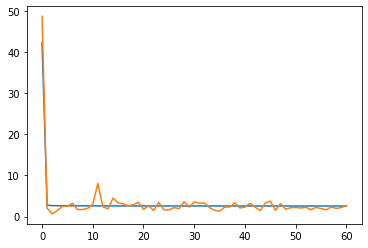

In [27]:
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, Dropout, FanInConcat,
                                   FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, SumPool, LogSoftmax)

def sigmoid(x): return expit(x)
def elu(x): return np.where(x > 0, x, np.expm1(x))
def leaky_relu(x): return np.where(x >= 0, x, 0.01 * x)
Sigmoid = stax.elementwise(sigmoid)
Elu = stax.elementwise(elu)
LeakyRelu = stax.elementwise(leaky_relu)
MinPool = stax._pooling_layer(jax.lax.max, -np.inf)

init_random_params, predict = stax.serial(
    GeneralConv(('NCHW', 'HWIO', 'NHWC'), 1, (1, 1), (1, 1), "SAME"),
    FanOut(2),
    stax.parallel(
        stax.serial(
            MinPool((3, 3), strides=(3, 3)),
            Dropout(0.5),
            Sigmoid,
            FanOut(2),
            stax.parallel(
                stax.serial(
                    MinPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid),
                stax.serial(
                    MaxPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid)),
            FanInConcat(1)),
        stax.serial(
            MaxPool((3, 3), strides=(3, 3)),
            Dropout(0.5),
            Sigmoid,
            FanOut(2),
            stax.parallel(
                stax.serial(
                    MinPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid),
                stax.serial(
                    MaxPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid)),
            FanInConcat(1))),
    FanInConcat(1),
    GeneralConv(('NHWC', 'HWIO', 'NHWC'), 2, (3, 3), (1, 1), "SAME"),
    Sigmoid,
    GeneralConv(('NHWC', 'HWIO', 'NHWC'), 1, (1, 1), (1, 1), "SAME"),
    Dense(16), Sigmoid,
    Dropout(0.5),
    Dense(16), Sigmoid,
    Dropout(0.5),
    Dense(8), Sigmoid,
    Dense(1))

def loss(params, batch, **kwargs):
    inputs, targets = batch
    preds = predict(params, inputs, **kwargs)
    #print(inputs.shape, targets.shape, preds.shape)
    return np.mean((preds - targets) ** 2)

def accuracy(params, batch, **kwargs):
    inputs, targets = batch
    preds = predict(params, inputs, **kwargs)
    #print(inputs.shape, targets.shape, preds.shape)
    return np.mean((preds - targets) ** 2)

def test_accuracy(params):
    test_images = Parallel(n_jobs=num_cores)(delayed(gen)(i) for i in range(16))
    test_cc = Parallel(n_jobs=num_cores)(delayed(gen_target)(ti) for ti in test_images)

    test_images = np.squeeze(np.stack(test_images), 1).astype(np.float32)
    test_cc = np.squeeze(np.stack(test_cc), 1).astype(np.float32)
    test_acc = accuracy(params, (test_images, test_cc), rng=random.PRNGKey(0))
    return test_acc

def ccnet():
    init_rng = random.PRNGKey(0)
    step_size = 0.01
    momentum_mass = 0.9
    #train_images, _, test_images, _ = datasets.mnist(permute_train=True)
    num_train = train_images.shape[0]
    num_complete_batches, leftover = divmod(train_images.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    nun_epochs = 60

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_images[batch_idx], train_cc[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(loss)(params, batch, rng=rng), opt_state)

    _, init_params = init_random_params(init_rng, (-1, 2, dungeon_rows, dungeon_cols))
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    losses.append(train_acc)
    test_acc = test_accuracy(params)
    test_accs.append(test_acc)
    print("Epoch init ")
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        for _ in range(num_batches):
            opt_state = update(rng, next(itercount), opt_state, next(batches))
        params = get_params(opt_state)
        train_acc = accuracy(params, (train_images, train_cc), rng=rng)
        losses.append(train_acc)
        test_acc = test_accuracy(params)
        test_accs.append(test_acc)
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_acc))
        print("Test set accuracy {}".format(test_acc))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

cc_params = ccnet()
cc_params

In [28]:
%%script false
import graphviz as gv

src = gv.Source(jax.api._make_graphviz(predict)(params, train_images, rng=random.PRNGKey(0)))
#print(src.source)
src.view()

NameError: name 'params' is not defined

In [29]:
print("Test set accuracy {}".format(test_accuracy(cc_params)))

Test set accuracy 2.1250545978546143


Alright, let's have a second go at a loss function. This one will try to both minimize density and the number of connected components.

Input shape: (1024, 2, 12, 12)
Output shape (1024,)
Num Epochs: 32
Num Batches: 32

Starting training...
Epoch init 
Epoch 0 in 3.46 sec
Training set accuracy 11.202980041503906
Test set accuracy 11.203014373779297
Epoch 1 in 0.09 sec
Training set accuracy 11.202762603759766
Test set accuracy 11.202796936035156
Epoch 2 in 0.09 sec
Training set accuracy 11.202499389648438
Test set accuracy 11.202518463134766
Epoch 3 in 0.11 sec
Training set accuracy 11.202255249023438
Test set accuracy 11.202220916748047
Epoch 4 in 0.10 sec
Training set accuracy 11.2019624710083
Test set accuracy 11.20201587677002
Epoch 5 in 0.09 sec
Training set accuracy 11.201729774475098
Test set accuracy 11.201749801635742
Epoch 6 in 0.10 sec
Training set accuracy 11.201454162597656
Test set accuracy 11.201436996459961
Epoch 7 in 0.10 sec
Training set accuracy 11.201142311096191
Test set accuracy 11.201162338256836
Epoch 8 in 0.10 sec
Training set accuracy 11.200900077819824
Test set accuracy 11.200922012329102
Epoc

DeviceArray([[[[ 0.10287727,  0.10235452,  0.10287208],
               [ 0.10236046,  0.1018059 ,  0.10235792],
               [ 0.10288865,  0.10236728,  0.10288722]],

              [[ 0.10285583,  0.10233226,  0.10285945],
               [ 0.10232844,  0.1017708 ,  0.10232976],
               [ 0.10285083,  0.10232411,  0.10284958]]],


             [[[-0.03666348, -0.04950946, -0.03665725],
               [-0.0495152 , -0.06348896, -0.04950781],
               [-0.03665419, -0.04950089, -0.03664771]],

              [[-0.03674426, -0.04959929, -0.03673775],
               [-0.0496028 , -0.0635852 , -0.04959623],
               [-0.03675073, -0.04960567, -0.03674564]]]], dtype=float32)

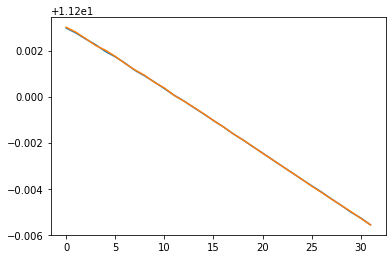

In [71]:
@jit
def dungeon_loss_2(params, batch):
    '''Simultaneously lower density and number of connected components'''
    x, y = batch
    out = dungeon(params, x)
    # map 0.0, 1.0 to -1.0, 1.0, convolve with kernel
    e = np.sum(out)
    v = np.prod(np.array(out.shape))
    # d=density
    d = 2. * e / (v * (v - 1.))
    cc = predict(cc_params, out, rng=random.PRNGKey(0))
    return np.mean(((d + cc) - y) ** 2.)

def dungeon_opt_2():
    init_rng = random.PRNGKey(1)
    step_size = 0.05
    momentum_mass = 0.9
    num_epochs = 32
    batch_size = 32
    train_X = np.squeeze(np.array([onp.random.rand(1, 2, dungeon_rows, dungeon_cols) for _ in range(num_epochs * batch_size)]), 1)
    train_y = np.array([1. for _ in range(train_X.shape[0])])
    num_train = train_X.shape[0]
    num_complete_batches, leftover = divmod(train_X.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    print("Input shape:", train_X.shape)
    print("Output shape", train_y.shape)
    print("Num Epochs:", num_epochs)
    print("Num Batches:", num_batches)

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_X[batch_idx], train_y[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(dungeon_loss_2)(params, batch), opt_state)

    #init_params = onp.random.randn(2, 2, 5, 5) * onp.sqrt(2/(2 + 5 + 5))
    init_params = jax.numpy.ones((2, 2, 3, 3))/(3.*3.)
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    #train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    #losses.append(train_acc)
    #test_acc = test_accuracy(params)
    #test_accs.append(test_acc)
    print("Epoch init ")
    #print("Training set accuracy {}".format(train_acc))
    #print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        epoch_batch = None
        for _ in range(num_batches):
            batch = next(batches)
            epoch_batch = batch
            opt_state = update(rng, next(itercount), opt_state, batch)
        params = get_params(opt_state)
        losses.append(dungeon_loss_2(params, epoch_batch))
        test_accs.append(dungeon_loss_2(params, next(batches)))
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(losses[-1]))
        print("Test set accuracy {}".format(test_accs[-1]))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

dungeon_params_2 = dungeon_opt_2()
dungeon_params_2

And this is the result of generating a new dungeon.

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  4  4  0]
 [ 0  0  0 ...  0  4  0]
 ...
 [12 12 12 ... 15 15 15]
 [12 12 12 ... 15 15 15]
 [12 12 12 ... 15 15 15]]
[[   0    6    1    9    4    5    7    8   14   12   15   13   11   10
     3    2]
 [1296  199  194  116   93   62   51   38   23   23   19   19   19   19
    19   19]]


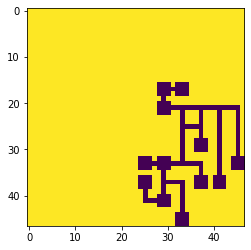

In [72]:
d = onp.random.binomial(1, dungeon(dungeon_params_2, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
t = connected_components(draw_dense_dungeon(d) * -1. + 1.)
sess = tf.Session();
with sess.as_default():
    #print(t.eval())
    te = t.eval()
    print(te)
    a = onp.array(onp.unique(te, return_counts=True))
    sorted_cc = a[:, a[1,:].argsort()[::-1]]
    print(sorted_cc)
    plt.imshow(onp.where(te == sorted_cc[0, 1], 0., 1.), vmin=0., vmax=1.)

Here are man new dungeons. Let's note that the dungeons are mostly tree-shaped - lots of branches with few loops. That makes sense, loops are likely to get pruned when optimizing for low density. How would you modify the loss function to penalize dead-ends?

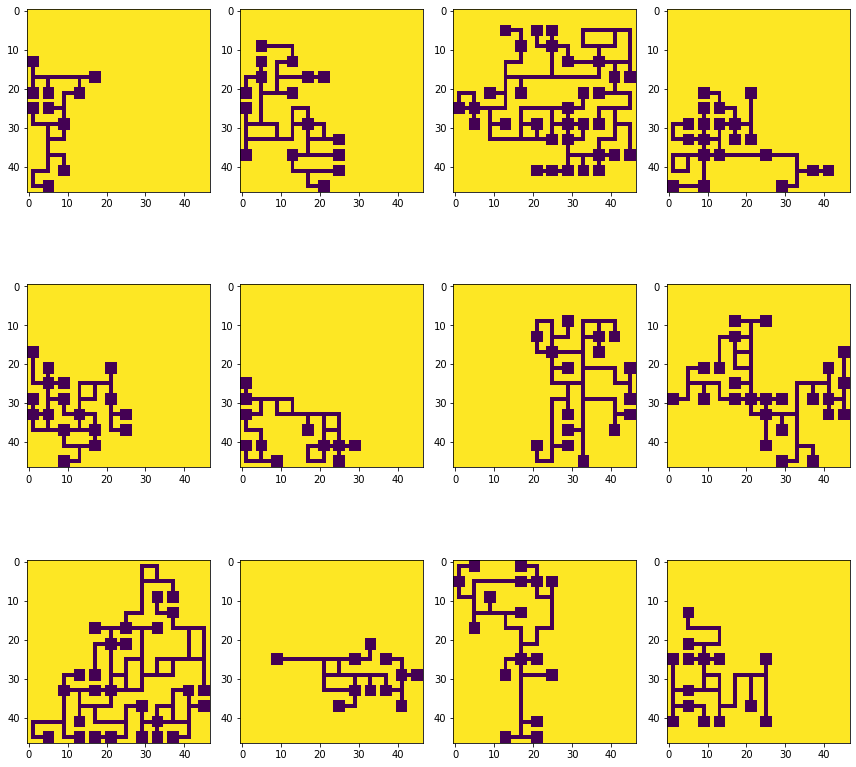

In [73]:
plt.subplots(figsize=(12, 12))
sess = tf.Session();
with sess.as_default():
    for i in range(1, 4):
        for j in range(1, 5):
            d = onp.random.binomial(1, dungeon(dungeon_params_2, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
            t = connected_components(draw_dense_dungeon(d) * -1. + 1.).eval()
            a = onp.array(onp.unique(t, return_counts=True))
            sorted_cc = a[:, a[1,:].argsort()[::-1]]
            #print(4, 5, (i - 1) * 4 + j)
            plt.subplot(3, 4, (i - 1) * 4 + j)
            plt.imshow(onp.where(t == sorted_cc[0, 1], 0., 1.), vmin=0., vmax=1.)
plt.tight_layout()

# Conclusion

I hope this notebook can help you explore the world of differentiable procgen. There are many ways to approach procedural generation and maybe having another tool in your belt can help you solve the right problem when you encounter it in the future.